In [ ]:
import pandas as pd
from google.colab import drive
import zipfile
import os
import h5py
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the path to your ZIP file
zip_file_path = '/content/drive/MyDrive/DS Project Course/Project3/archive.zip'

# Specify the directory where you want to extract the contents
extract_to = '/content/extracted_files'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Check the contents of the extracted folder
print(os.listdir(extract_to))

['food_c101_n10099_r64x64x3.h5', 'food_test_c101_n1000_r64x64x1.h5', 'images', 'food_test_c101_n1000_r128x128x3.h5', 'food_test_c101_n1000_r64x64x3.h5', 'food_c101_n1000_r384x384x3.h5', 'food_c101_n10099_r64x64x1.h5', 'food_c101_n10099_r32x32x1.h5', 'meta', 'food_test_c101_n1000_r32x32x1.h5', 'food_test_c101_n1000_r32x32x3.h5', 'food_c101_n10099_r32x32x3.h5', 'food_test_c101_n1000_r128x128x1.h5']


In [ ]:
import os

# Specify the directory you want to walk through
directory_path = '/content/extracted_files'

# Walk through the directory and print the full paths of the files
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/extracted_files/images/pizza/54461.jpg
/content/extracted_files/images/pizza/857888.jpg
/content/extracted_files/images/pizza/918506.jpg
/content/extracted_files/images/pizza/2091857.jpg
/content/extracted_files/images/pizza/2292986.jpg
/content/extracted_files/images/pizza/3193599.jpg
/content/extracted_files/images/pizza/1107714.jpg
/content/extracted_files/images/pizza/618348.jpg
/content/extracted_files/images/pizza/3042459.jpg
/content/extracted_files/images/pizza/419962.jpg
/content/extracted_files/images/pizza/1351146.jpg
/content/extracted_files/images/pizza/3530210.jpg
/content/extracted_files/images/pizza/979933.jpg
/content/extracted_files/images/pizza/2462190.jpg
/content/extracted_files/images/pizza/3333459.jpg
/content/extracted_files/images/pizza/698251.jpg
/content/extracted_files/images/pizza/340814.jpg
/content/extracted_files/images/pizza/93961.jpg
/content/extracted_files/images/pizza/2572958.jpg
/content/e

In [ ]:
!pip install h5py

In [ ]:
import h5py

# Load and process h5 files
def load_dataset_in_batches(file_path, batch_size=32):
    with h5py.File(file_path, 'r') as f:
        num_samples = f['images'].shape[0]
        for i in range(0, num_samples, batch_size):
            images = f['images'][i:i+batch_size] / 255.0  # Normalize
            labels = f['category'][i:i+batch_size]
            yield images, labels

# Preprocessing Data
def preprocess_data(images, labels):
    num_classes = labels.shape[1]
    return images, labels, num_classes

In [ ]:
# Build the CNN Model
def build_cnn_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Train and Evaluate the Model
def train_and_evaluate(file_path, description, batch_size=32):
    print(f"\nProcessing dataset: {description}")

    # Load dataset metadata
    with h5py.File(file_path, 'r') as f:
        input_shape = f['images'].shape[1:]
        num_classes = f['category'].shape[1]

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Build model
    model = build_cnn_model(input_shape, num_classes)

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # Training in batches to save memory
    batch_generator = load_dataset_in_batches(file_path, batch_size)
    X_val, y_val = next(load_dataset_in_batches(file_path, batch_size))  # Use one batch as validation set

    # Train model
    history = model.fit(
        datagen.flow(X_val, y_val, batch_size=batch_size),
        validation_data=(X_val, y_val),
        epochs=50,
        callbacks=callbacks
    )

    # Evaluate model
    X_test, y_test = next(load_dataset_in_batches(file_path, batch_size))
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Results for {description}: Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Classification report and confusion matrix
    print(classification_report(y_true_classes, y_pred_classes))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix: {description}")
    plt.show()


Processing dataset: 32x32x3


<ipython-input-7-1abd6e5a6b6b>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.0000e+00 - loss: 4.6202 - val_accuracy: 0.0312 - val_loss: 4.5997 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 4.6390 - val_accuracy: 0.0000e+00 - val_loss: 4.5910 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.0312 - loss: 4.5970 - val_accuracy: 0.0000e+00 - val_loss: 4.5816 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.0312 - loss: 4.5946 - val_accuracy: 0.0000e+00 - val_loss: 4.5715 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.0000e+00 - loss: 4.6043 - val_accuracy: 0.0312 - val_loss: 4.5612 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.0938 - loss: 4.5351 - val_accuracy: 0.0312 - val_loss: 4.5508 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0312 - loss: 4.5413 - val_a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


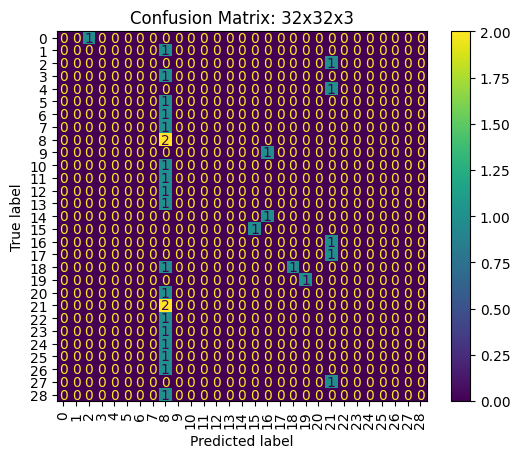

In [ ]:
# Train and evaluate on 32x32x3 images
train_and_evaluate('/content/extracted_files/food_c101_n10099_r32x32x3.h5', "32x32x3", batch_size=32)
# Showcases results and confusion matrix


Processing dataset: 64x64x3


<ipython-input-7-1abd6e5a6b6b>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.0312 - loss: 5.3418 - val_accuracy: 0.0312 - val_loss: 4.7373 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.0312 - loss: 5.2044 - val_accuracy: 0.0938 - val_loss: 4.4134 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.0312 - loss: 4.9106 - val_accuracy: 0.1250 - val_loss: 4.1066 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.0000e+00 - loss: 4.5217 - val_accuracy: 0.1250 - val_loss: 3.8281 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.0938 - loss: 4.3419 - val_accuracy: 0.1562 - val_loss: 3.5789 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.0938 - loss: 4.1965 - val_accuracy: 0.2500 - val_loss: 3.3567 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1875 - loss: 3.7988 - val_accuracy: 0.3438 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


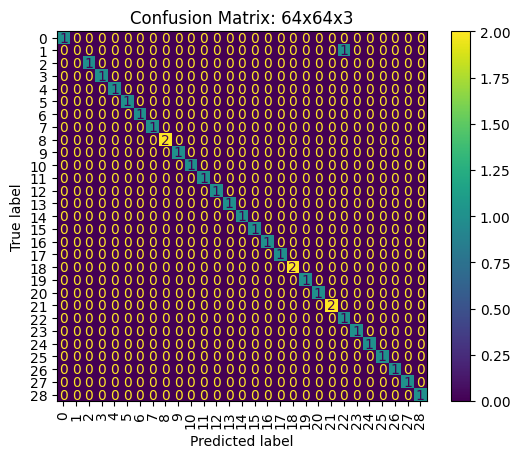

In [ ]:
# Train and evaluate on 64x64x3 images
train_and_evaluate('/content/extracted_files/food_c101_n10099_r64x64x3.h5', "64x64x3", batch_size=32)


Processing dataset: 384x384x3


<ipython-input-7-1abd6e5a6b6b>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.0312 - loss: 4.8429 - val_accuracy: 0.0312 - val_loss: 4.4671 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0312 - loss: 4.6470 - val_accuracy: 0.0625 - val_loss: 4.2055 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0312 - loss: 4.4035 - val_accuracy: 0.1250 - val_loss: 3.9992 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0312 - loss: 4.2373 - val_accuracy: 0.1562 - val_loss: 3.8188 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1875 - loss: 3.9672 - val_accuracy: 0.2188 - val_loss: 3.6385 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1875 - loss: 3.7558 - val_accuracy: 0.3438 - val_loss: 3.4568 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1250 - loss: 3.6616 - val_accuracy: 0.4375 - val_loss: 3.2647 - le

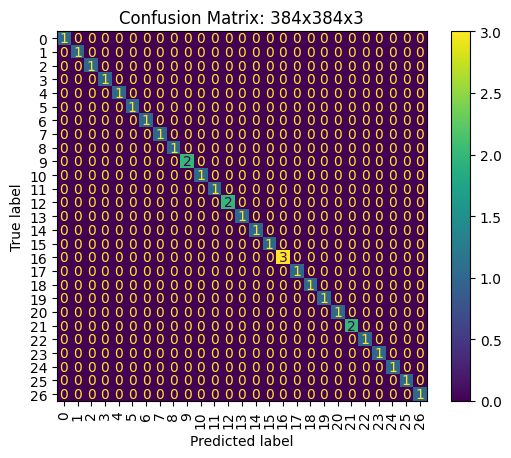

In [ ]:
# Train and evaluate on 384x384x3 images
train_and_evaluate('/content/extracted_files/food_c101_n1000_r384x384x3.h5', "384x384x3", batch_size=32)